# Running MAGIC and PHATE on A549 TGF-B EMT data
**Author:** Scott Campit

# Summary
This notebook performs data imputation using MAGIC for single-cell COBRA analyses.

To visualize the results, we will use PHATE, which was also developed in the same lab.

In [4]:
#!pip install --user magic-impute
#!pip install --user phate
import magic
import phate
import scprep

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# Read excel files
import xlrd
import openpyxl
from openpyxl import load_workbook

import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

c:\Users\Scott\Envs\Python\emt\Scripts\python.exe
3.8.6 (tags/v3.8.6:db45529, Sep 23 2020, 15:52:53) [MSC v.1927 64 bit (AMD64)]
sys.version_info(major=3, minor=8, micro=6, releaselevel='final', serial=0)


# 1. Import data
First, let's import the single-cell A549 data. 

In [66]:
# Dell
datapath = r"D:\Analysis\EMT\a549_tgfb_preprocessed_for_magic.csv"
data = pd.read_csv(datapath, sep=' ')

                       FO538757.2  AP006222.2  RP11-206L10.9  FAM41C  \
Mix1_AAGCCGCAGGAATCGC    0.000000    0.000000            0.0     0.0   
Mix1_AGCGGTCTCACCACCT    0.000000    1.159458            0.0     0.0   
Mix1_AGTCTTTGTGCAACGA    0.000000    1.095043            0.0     0.0   
Mix1_ATTTCTGCAACTGCGC    0.977895    0.977895            0.0     0.0   
Mix1_CACCACTTCAACACCA    0.000000    0.791498            0.0     0.0   
Mix1_CCTCTGAGTTGTACAC    0.000000    0.000000            0.0     0.0   
Mix1_CGTCCATTCCGAGCCA    0.000000    0.000000            0.0     0.0   
Mix1_CTGCCTACATGCATGT    0.000000    0.000000            0.0     0.0   
Mix1_GAATGAACACACATGT    0.000000    1.232911            0.0     0.0   
Mix1_GACGCGTAGGCTAGCA    0.000000    0.000000            0.0     0.0   

                         SAMD11     NOC2L  KLHL17  PLEKHN1      HES4  \
Mix1_AAGCCGCAGGAATCGC  0.000000  1.013941     0.0  0.00000  0.000000   
Mix1_AGCGGTCTCACCACCT  1.639722  1.639722     0.0  0.00000  0.0

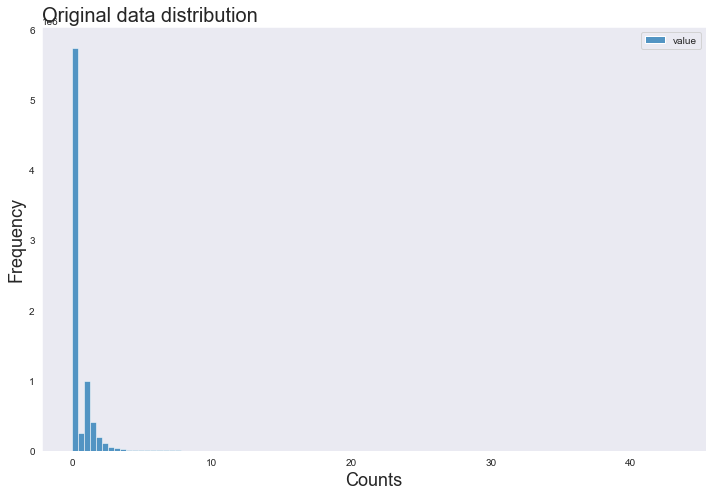

In [67]:
print(data.head(10))

fig, ax = plt.subplots(1, figsize=(10,7))
sns.histplot(data=pd.melt(data), ax=ax,
             bins=100)
sns.set_style("dark")

ax.set_xlabel('Counts', fontsize=18)
ax.set_ylabel('Frequency', fontsize=18)
ax.set_title('Original data distribution', fontsize=20, loc='left')

fig.tight_layout()

# 2. Data Preprocessing on a Single Cell Lineage
Let's now perform some data filtering.

## 2a. Filtering by library size
The library size of a cell is the number of unique mRNA molecules in the cell. As an arbitrary threshold, we will remove all cells that have fewer than 500 reads per cell.

<AxesSubplot:xlabel='Library size', ylabel='Number of cells'>

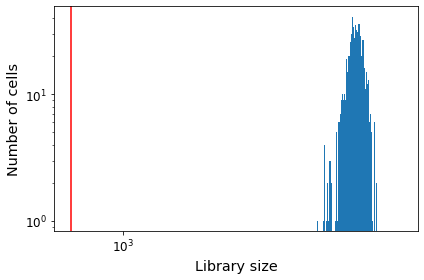

In [14]:
scprep.plot.plot_library_size(data=data,
                              cutoff=250)

<AxesSubplot:xlabel='Library size', ylabel='Number of cells'>

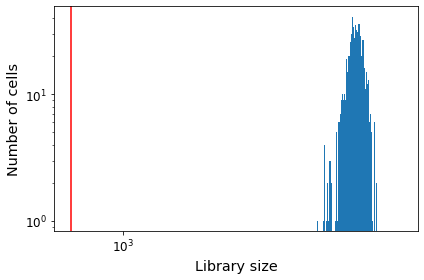

In [15]:
# be sure to uncomment this, unless your data is pre-filtered
data = scprep.filter.filter_library_size(data, cutoff=250)
scprep.plot.plot_library_size(data=data,
                              cutoff=250)

## 2b. Filtering lowly expressed genes
Now let's filter lowly expressed genes. First, we'll get a count of the number of genes that are expressed in each cell.

In [16]:
genes_per_cell = np.sum(data > 0, axis=0)

Then, let's visualize the data. There are several genes showing very little expression. We'll remove rarely-expressed genes.

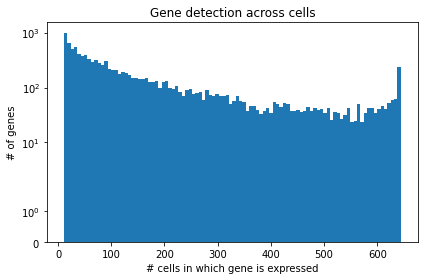

In [17]:
fig, ax = plt.subplots(1, figsize=(6,4))
ax.hist(genes_per_cell, bins=100)
ax.set_xlabel('# cells in which gene is expressed')
ax.set_ylabel('# of genes')
ax.set_yscale('symlog')
ax.set_title('Gene detection across cells')
fig.tight_layout()

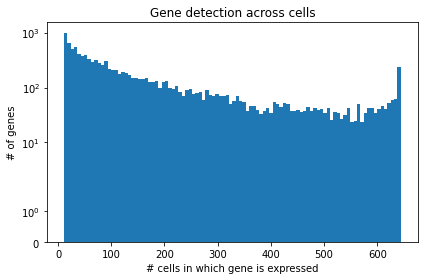

In [18]:
data = scprep.filter.remove_rare_genes(data, cutoff=0, min_cells=5)
fig, ax = plt.subplots(1, figsize=(6,4))
ax.hist(genes_per_cell, bins=100)
ax.set_xlabel('# cells in which gene is expressed')
ax.set_ylabel('# of genes')
ax.set_yscale('symlog')
ax.set_title('Gene detection across cells')
fig.tight_layout()

In [19]:
print(data.shape)

(644, 12294)


# 3. Run MAGIC on a Single Cell Lineage
Now let's run MAGIC for data imputation with the normalized and filtered data.

In [21]:
magic_op = magic.MAGIC()
a549_magic = magic_op.fit_transform(data, genes="all_genes")

Calculating MAGIC...
  Running MAGIC on 644 cells and 12294 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.70 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.05 seconds.
    Calculating affinities...
    Calculated affinities in 0.05 seconds.
  Calculated graph and diffusion operator in 0.84 seconds.
  Running MAGIC with `solver='exact'` on 12294-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 0.12 seconds.
Calculated MAGIC in 1.01 seconds.


We can visualize the distribution of the imputed data.

<AxesSubplot:xlabel='Library size', ylabel='Number of cells'>

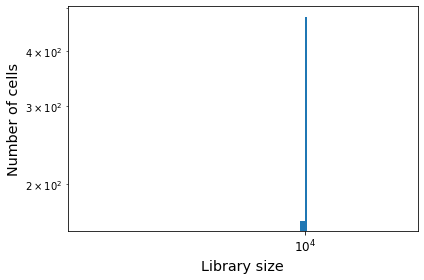

In [22]:
scprep.plot.plot_library_size(data=a549_magic)

In [24]:
import seaborn as sns

In [26]:
a549_magic = a549_magic.round(decimals=4)
print(a549_magic)

                        FO538757.2  AP006222.2  RP11-206L10.9  FAM41C  SAMD11  \
Mix1_AAGCCGCAGGAATCGC       0.2798      0.4081         0.0178  0.1591  0.5932   
Mix1_AGCGGTCTCACCACCT       0.2477      0.5571         0.0253  0.1348  0.8503   
Mix1_AGTCTTTGTGCAACGA       0.2868      0.5376         0.0548  0.1514  0.7672   
Mix1_ATTTCTGCAACTGCGC       0.2928      0.4548         0.0144  0.1760  0.8700   
Mix1_CACCACTTCAACACCA       0.2671      0.4200         0.0145  0.1712  0.6370   
...                            ...         ...            ...     ...     ...   
Mix4b_TCGCGAGAGCTACCTA      0.2941      0.5117         0.0682  0.2758  0.9839   
Mix4b_TGCCCATTCGCCATAA      0.2419      0.4847         0.0294  0.2390  0.6842   
Mix4b_TTAACTCTCCTTTCGG      0.3010      0.4165         0.0251  0.2180  0.7365   
Mix4b_TTGAACGTCTCTGAGA      0.3278      0.4721         0.0399  0.2324  0.7054   
Mix4b_TTTACTGCATCGGAAG      0.3264      0.4311         0.0495  0.2291  0.8495   

                         NO

In [27]:
a549_magic[~np.isfinite(a549_magic)] = 0

Now let's make a heatmap of the data

<AxesSubplot:ylabel='Count'>

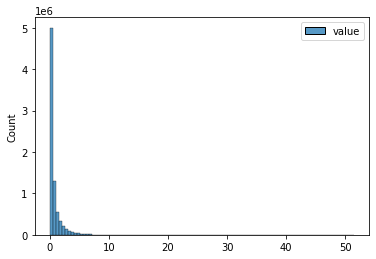

In [28]:
sns.histplot(data=pd.melt(a549_magic),
             bins=100)

Now let's transform the normalized data into a robust Z-score and get a p-value out of it. We'll compute gene-wise Z-scores.

In [29]:
from scipy.stats import median_absolute_deviation as mad
mu = a549_magic.median(axis=0)
n = a549_magic.shape[1]
med_abs_dev = mad(a549_magic)
scale_factor = 1.4826
Z = (a549_magic - mu) / (med_abs_dev * scale_factor)
print(Z)

<ipython-input-29-b04789f4093a>:4: DeprecationWarning: `median_absolute_deviation` is deprecated, use `median_abs_deviation` instead!

To preserve the existing default behavior, use
`scipy.stats.median_abs_deviation(..., scale=1/1.4826)`.
The value 1.4826 is not numerically precise for scaling
with a normal distribution. For a numerically precise value, use
`scipy.stats.median_abs_deviation(..., scale='normal')`.

  med_abs_dev = mad(a549_magic)
                        FO538757.2  AP006222.2  RP11-206L10.9    FAM41C  \
Mix1_AAGCCGCAGGAATCGC    -0.105819   -0.455415      -0.587766 -0.634319   
Mix1_AGCGGTCTCACCACCT    -0.640746    0.965670      -0.338713 -1.159497   
Mix1_AGTCTTTGTGCAACGA     0.010832    0.779689       0.640898 -0.800734   
Mix1_ATTTCTGCAACTGCGC     0.110818   -0.010014      -0.700671 -0.269072   
Mix1_CACCACTTCAACACCA    -0.317457   -0.341919      -0.697350 -0.372811   
...                            ...         ...            ...       ...   
Mix4b_TCGCGAGAGCTACCTA   

Now let's plot the resulting distribution from taking the Z-score.

<AxesSubplot:ylabel='Count'>

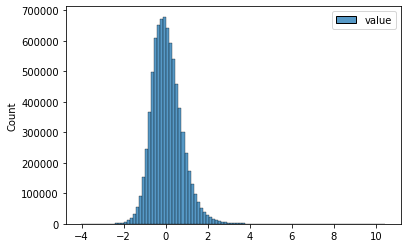

In [30]:
Z[~np.isfinite(Z)] = 0

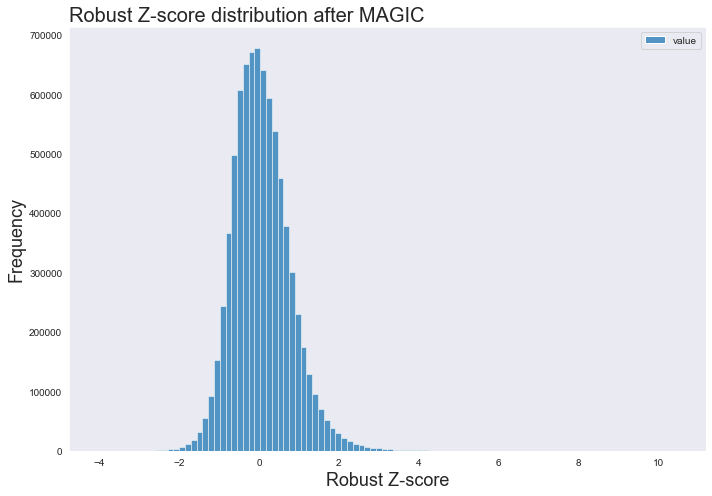

In [65]:
fig, ax = plt.subplots(1, figsize=(10,7))
sns.histplot(data=pd.melt(Z), ax=ax,
             bins=100)
sns.set_style("dark")

ax.set_xlabel('Robust Z-score', fontsize=18)
ax.set_ylabel('Frequency', fontsize=18)
ax.set_title('Robust Z-score distribution after MAGIC', fontsize=20, loc='left')

fig.tight_layout()

In [55]:
from scipy.stats import norm
pval = norm.sf(abs(Z))*2 
print(pval.shape)

(644, 12294)


Now let's plot the data

In [62]:
tmp = pval.flatten()
colmap = []
for i in tmp:
    if i < 0.05:
        colmap.append('#FF0000')
    else:
        colmap.append('#696969')

ValueError: RGBA sequence should have length 3 or 4

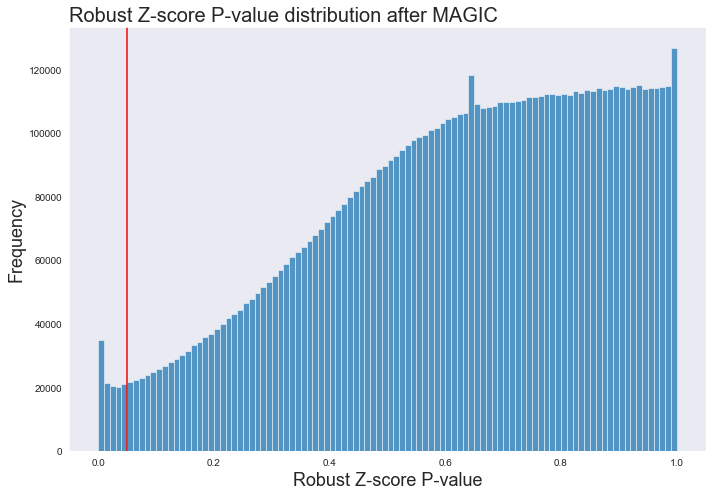

In [64]:
fig, ax = plt.subplots(1, figsize=(10,7))
sns.histplot(data=tmp,
             bins=100, ax=ax)

sns.set_style("dark")

ax.set_xlabel('Robust Z-score P-value', fontsize=18)
ax.set_ylabel('Frequency', fontsize=18)
ax.set_title('Robust Z-score P-value distribution after MAGIC', fontsize=20, loc='left')
plt.axvline(x=0.05, color='r')

fig.tight_layout()

Now let's save the data as a dataframe

In [32]:
pval = pd.DataFrame(pval,
                    index=a549_magic.index,
                    columns=a549_magic.columns)

# 4. Run PHATE
Now let's perform dimension reduction.

Calculating PHATE...
  Running PHATE on 644 observations and 12294 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 1.08 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.04 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 1.15 seconds.
  Calculating optimal t...
    Automatically selected t = 24
  Calculated optimal t in 0.37 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.03 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.30 seconds.
Calculated PHATE in 1.86 seconds.
c:\Users\Scott\Envs\Python\emt\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


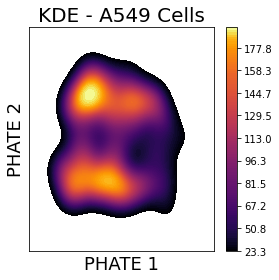

In [34]:
phate_op = phate.PHATE()
a549_phate = phate_op.fit_transform(a549_magic)

Now let's visualize the data

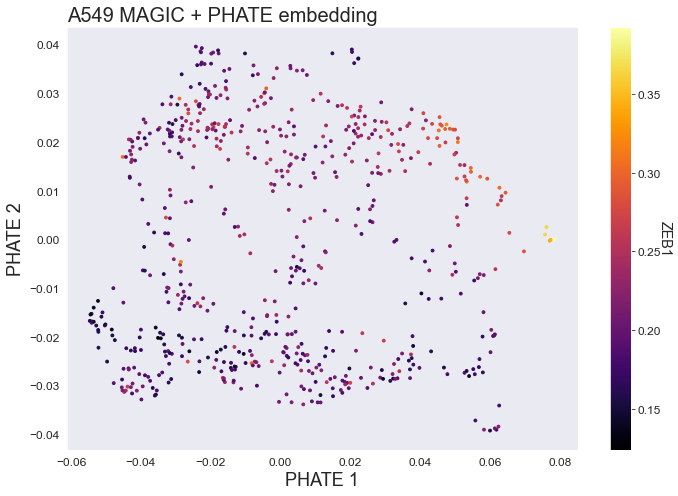

In [53]:
import seaborn as sns

fig, ax = plt.subplots(1, figsize=(10,7))

# Density plot
#sns.kdeplot(a549_phate[:,0], 
#            a549_phate[:,1], 
#            n_levels=100, 
#            shade=True, 
#            cmap='inferno', 
#            zorder=0, 
#            ax=ax,
#            cbar=True)

# Scatterplot
scprep.plot.scatter(a549_phate[:,0], 
            a549_phate[:,1],
            c=a549_magic['ZEB1'], 
            ax=ax,
            legend_title="ZEB1")
sns.set_style("dark")
#ax.set_xticks([])
#ax.set_yticks([])

ax.set_xlabel('PHATE 1', fontsize=18)
ax.set_ylabel('PHATE 2', fontsize=18)
ax.set_title('A549 MAGIC + PHATE embedding', fontsize=20, loc='left')

fig.tight_layout()

# 4. Create a Function That Performs MAGIC Imputation for All Cell Types
Now that we have walked through the steps of a single lineage and found that the data distribution appears more "Normal", we can repeat this for all immune cell types. 

First, let's define a function to compute some robust standardized data using the robust Z-score method.

In [ ]:
from scipy.stats import median_absolute_deviation as mad
from scipy.stats import norm

def robust_zscore(df):
    """
    robust_zscore computes a modified version of the Z-score centered around the media and scaled by the median absolute deviation.
    INPUT:
      :param df: A data frame corresponding to numerical values where rows correspond to cells and columns correspond to genes.
    OUTPUTS:
      :output Z: A data frame of the robust Z-scores.
      :output pval: A data frame of the p-values corresponding to the robust Z-scores.

    """
    # Compute model parameters
    mu = df.median(axis=0)
    n = df.shape[1]
    med_abs_dev = mad(df)
    scale_factor = 1.4826

    # Compute robust Z-score
    Z = (df - mu) / (med_abs_dev * scale_factor)
    Z[~np.isfinite(Z)] = 0

    # Compute P-value based on Z-score
    pval = norm.sf(abs(Z))*2 
    pval = pd.DataFrame(pval,
                    index=df.index,
                    columns=df.columns)
    return(Z, pval)

Next, we'll define a function that runs the MAGIC pipeline described above.

In [ ]:
def MAGIC_pipeline(df):
    """
    MAGIC_pipeline performs data preprocessing, MAGIC imputation, and data standardization.
    INPUT: 
      :param df: A pandas dataframe of the raw counts data.
    OUTPUT:
      :param Z: A pandas dataframe of the Z-scores that reach a p-value threshold less than 0.05.
    """
    # Drop symbols
    df = df[df['NCBI.gene..formerly.Entrezgene..ID'].notna()]
    ids = df["NCBI.gene..formerly.Entrezgene..ID"]
    df = df.drop(['MGI.symbol', 
                  'HGNC.symbol', 
                  'NCBI.gene..formerly.Entrezgene..ID', 
                  'Gene.stable.ID',
                  'Ensembl'], axis=1)

    # Grab cell names
    celltype = df.columns

    # Annotate and configure data
    df = df.transpose()
    df = df.reset_index()
    df = df.drop('index', axis=1)
    df.columns = ids
    df.index = celltype

    # Perform some data filtering
    df = scprep.filter.filter_library_size(df, cutoff=250)
    df = scprep.filter.remove_rare_genes(df, cutoff=0, min_cells=5)

    # Perform count normalization and square root transformation.
    df = scprep.normalize.library_size_normalize(df)
    df = scprep.transform.sqrt(df)

    # Data imputation with MAGIC
    magic_op = magic.MAGIC()
    magic_data = magic_op.fit_transform(df, genes="all_genes")
    magic_data = magic_data.round(decimals=4)
    magic_data[~np.isfinite(magic_data)] = 0

    # Compute Z-scores
    Z, pvalue = robust_zscore(magic_data)
    Z[pvalue > 0.05] = np.NaN

    return(Z)

Finally, let's iterate this pipeline across all cell types. I ended up having to delete the cache for memory intensive purposes. Also, ensure the virtual environment is using the 64 bit version of Python, otherwise you will run into memory issues.

In [ ]:
for celltypes in wb.sheetnames: 
    counts = pd.read_excel(datapath, 
                        sheet_name=celltypes)
    Z = MAGIC_pipeline(counts)
    del counts

    # ACLX
    #Z.to_csv('C:/Users/scott/Analysis/Immune/'+celltypes+'_magic.csv')

    # Dell
    Z.to_csv('D:/Analysis/Immune/magic_entrez/'+celltypes+'_magic.csv')

    del Z